In [52]:
# Authors: Rahul Ramachandran and Rishit D

# Importing the required libraries
try:
    import numpy as np
    import pandas as pd
    import ucimlrepo
    from sklearn.linear_model import LinearRegression
    from statsmodels.miscmodels.ordinal_model import OrderedModel
    import scipy.stats as stats
    import matplotlib.pyplot as plt
except:
    print(f'[INFO] Installing the required libraries')
    %pip install numpy, pandas, ucimlrepo, scikit-learn, statsmodels, scipy, matplotlib
    import numpy as np
    import pandas as pd
    import ucimlrepo
    from sklearn.linear_model import LinearRegression
    from statsmodels.miscmodels.ordinal_model import OrderedModel
    import scipy.stats as stats
    import matplotlib.pyplot as plt


# Dataset
This notebook uses the [UCI Wine Quality Dataset](https://archive.ics.uci.edu/dataset/186/wine+quality), which is a classification/regression dataset. The goal is to predict the quality of the wine based on its chemical properties. The dataset contains 4898 instances and 11 features. 

Two methods are used to predict the quality of wine in this notebook: [Linear Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) and [Ordinal Regression](https://www.statsmodels.org/stable/examples/notebooks/generated/ordinal_regression.html).

In [53]:
from ucimlrepo import fetch_ucirepo 

# fetch dataset 
wine_quality = fetch_ucirepo(id=186) 
print(f'[INFO] Dataset loaded successfully')

# data (as pandas dataframes) 
X = wine_quality.data.features 
y = wine_quality.data.targets 

# metadata 
print(wine_quality.metadata) 
# variable information 
print(wine_quality.variables) 

[INFO] Dataset loaded successfully
{'uci_id': 186, 'name': 'Wine Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/186/wine+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/186/data.csv', 'abstract': 'Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/).', 'area': 'Business', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 4898, 'num_features': 11, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['quality'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C56S3T', 'creators': ['Paulo Cortez', 'A. Cerdeira', 'F. Almeida', 'T. Matos', 'J. Reis'], 'intro_paper': {'title': 'Modeling wine prefe

In [54]:
# `evaluate` calculates the evaluation metrics (MAE, MSE, Ratio of Correct Predictions, Almost Correct Predictions) for the model.
def evaluate(y_true, y_pred, pred_type:str, verbose:bool=True)->float:
    """Prints the evaluation metrics for the model. 
    This includes:
        Mean Absolute Error (MAE), Mean Squared Error (MSE), Ratio of Correct Predictions, Almost Correct Predictions (Difference of 1)
    params:
        y_true: The true labels (np.array or pandas dataframe of predicted class (shape: (n, 1)) or probabilities (shape: (n, c)))
        y_pred: The predicted labels (np.array or pandas dataframe of predicted class (shape: (n, 1)))
        pred_type: The type of y_true (either 'probs' or 'labels')
        verbose: Whether to print the evaluation metrics or not
    returns:
        accuracy (float)
    """
    assert pred_type == 'probs' or pred_type == 'labels', "type must be either 'probs' or 'labels'"

    if pred_type == 'labels':
        pred, gt = y_pred, y_true
        if verbose:
            print(f'MAE: {np.mean(np.abs(pred - gt))}')
            print(f'MSE: {np.mean((pred - gt)**2)}')
            print(f'Correct Predictions: {np.sum(np.rint(pred) == gt)} out of {len(gt)}')
            print(f'Almost Correct Predictions: {np.sum(np.abs(np.rint(pred) - gt) <= 1)} out of {len(gt)}')
        return np.sum(np.rint(pred) == gt)/len(gt)
    else:
        probs, gt = y_pred, y_true
        pred = np.sum(probs * np.array(list(range(int(y.min().iloc[0]), int(y.max().iloc[0])+1))), axis=1)[:, np.newaxis] # To find MAE and MSE of probabilities, assume predictions are expected values
        if verbose:
            print(f'MAE: {np.mean(np.abs(pred - gt))}')
            print(f'MSE: {np.mean((pred - gt)**2)}')
            print(f'Correct Predictions: {np.sum(np.rint(pred) == gt)} out of {len(gt)}')
            print(f'Almost Correct Predictions: {np.sum(np.abs(np.rint(pred) - gt) <= 1)} out of {len(gt)}')
            print(f'Correct Predictions (using max): {np.sum((probs.argmax(1) + 3)[:, np.newaxis] == gt)} out of {len(gt)}')
            print(f'Almost Correct Predictions (using max): {np.sum(np.abs((probs.argmax(1) + 3)[:, np.newaxis] - gt) <= 1)} out of {len(gt)}')
        return np.sum((probs.argmax(1) + 3)[:, np.newaxis] == gt)/len(gt)

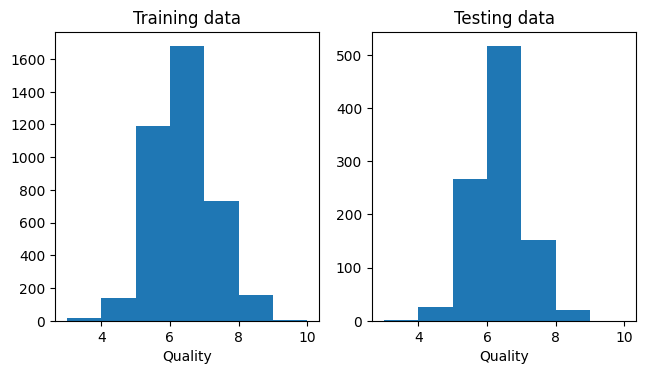

In [62]:
# Prepare training and testing data
from sklearn.model_selection import train_test_split

# Splitting the data into train and test sets (80:20)
nX, ny = len(X), len(y)
train_size = int(0.8 * nX)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Visualising the data
fig, axs = plt.subplots(nrows=1,
                        ncols=2,
                        figsize=(7.5, 3.75))

axs[0].hist(y_train, bins=7, range=(3, 10))
axs[0].set_title('Training data')
axs[0].set_xlabel('Quality')

axs[1].hist(y_test, bins=7, range=(3, 10))
axs[1].set_title('Testing data')
axs[1].set_xlabel('Quality')
plt.show()

# Linear Regression vs. Ordinal Regression
In this section we compare Linear Regression with Ordinal Regression. [Linear Regression](https://en.wikipedia.org/wiki/Linear_regression) simply fits a linear model to the data, and predicts the wine quality by rounding-off a predicted value.

On the other hand, [Ordinal Regression](https://en.wikipedia.org/wiki/Ordinal_regression) is a classification technique that assumes the underlying random variables are stochastically ordered. In other words, the buckets are "ordinal"; they have a natural ordering. For example, the quality of wine can be ordered as follows: $1 < 2 < 3 < 4 < 5 < 6 < 7 < 8 < 9$.

In [56]:
# Fit the Linear Regression Model
reg_model = LinearRegression().fit(X_train, y_train)
print(f'Linear Regression Score: {reg_model.score(X_train, y_train)}')

# Evaluate the Linear Regression Model
pred, gt = np.array(reg_model.predict(X_test))[:, np.newaxis], np.array(y_test)[:, np.newaxis]
acc = evaluate(gt, pred, 'labels')

Linear Regression Score: 0.29926906612869675
MAE: 0.5513533210016455
MSE: 0.507210463667933
Correct Predictions: 518 out of 980
Almost Correct Predictions: 942 out of 980


In [57]:
from pandas.api.types import CategoricalDtype

# Create an ordered categorical type for ordinal regression
print(f'Range of values: {int(y.min().iloc[0])} to {int(y.max().iloc[0])}')
ctype = CategoricalDtype(categories=list(range(int(y.min().iloc[0]), int(y.max().iloc[0])+1)),
                         ordered=True) # The qualities are ordered as min < min+1 < ... < max
y_train = y_train.astype(ctype) # Convert the training labels to the ordered categorical type

Range of values: 3 to 9


Here, we fit the Ordinal Regression Model. 


Since the output of `OrderedModel()` is a list of probabilities, we perform inferencing in two ways: we use the rounded expected values, as well as the maximum probability value. Both inferring methods are superior to linear regression.

In [58]:
# Fit the Ordinal Regression Model

# CLogLog for proportional hazards
class CLogLog(stats.rv_continuous):
    def _ppf(self, q):
        return np.log(-np.log(1 - q))

    def _cdf(self, x):
        return 1 - np.exp(-np.exp(x))


cloglog = CLogLog()

ord_model = OrderedModel(y_train, X_train, distr=cloglog)
ord_model = ord_model.fit(method='bfgs', maxiter=10000)

# Evaluate the Ordinal Regression Model
probs, gt = np.array(ord_model.model.predict(ord_model.params, X_test)), np.array(y_test)
acc = evaluate(gt, probs, 'probs')

Optimization terminated successfully.
         Current function value: 1.154877
         Iterations: 132
         Function evaluations: 138
         Gradient evaluations: 138
MAE: 0.5371400005088605
MSE: 0.4860243626072449
Correct Predictions: 541 out of 980
Almost Correct Predictions: 951 out of 980
Correct Predictions (using max): 553 out of 980
Almost Correct Predictions (using max): 949 out of 980
